In [1]:
import cartopy.crs
from cartopy import feature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean.cm
import numpy
import xarray
import pandas
import pathlib
import yaml

In [71]:
mesh_mask = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02")
water_mask = mesh_mask.tmaskutil.isel(time=0)

fields = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV19-05")
georef = xarray.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02")

location_dir = pathlib.Path('/Users/rmueller/Data/MIDOSS/AIS')
location_file = location_dir / 'Oil_Transfer_Facilities.xlsx'
wa_oil_in = pathlib.Path('/Users/rmueller/Data/MIDOSS/marine_transport_data') / 'WA_destination.yaml'
wa_oil_out = pathlib.Path('/Users/rmueller/Data/MIDOSS/marine_transport_data') / 'WA_origin.yaml'
spill_locations = '/Users/rmueller/Projects/MIDOSS/analysis-rachael/notebooks/data/SalishSea_oil_spills_10000.csv'

output_directory = pathlib.Path('/Users/rmueller/Documents/Presentations/2020/MEOPAR_ASM/graphics/')

In [3]:
vessel_types = [
    'tanker', 
    'atb', 
    'barge'
]
oil_types = [
    'akns', 
    'bunker', 
    'dilbit', 
    'jet', 
    'diesel', 
    'gas', 
    'other'
]
oil_colors = [
    'darkolivegreen',
    'olivedrab',
    'slategrey',
    'indigo',
    'mediumslateblue',
    'cornflowerblue',
    'saddlebrown'
]
gallons_to_liters = 3.78541

### Load data
read in oil attribute data and spill locations

In [4]:
with open(wa_oil_in) as file:
        oil_attrs_in = yaml.load(file, Loader=yaml.Loader)
        
with open(wa_oil_out) as file:
        oil_attrs_out = yaml.load(file, Loader=yaml.Loader)

wa_locs = pandas.read_excel(location_file, sheet_name='Washington', 
                   usecols="B,I,J")
bc_locs = pandas.read_excel(location_file, sheet_name='British Columbia', 
                   usecols="A,B,C")        
        
spill_locs = pandas.read_csv(spill_locations)

# clean up names and remove locations outside of Salish Sea
for location in wa_locs['FacilityName']:
    if location == 'Marathon Anacortes Refinery (formerly Tesoro)':
#         wa_locs[wa_locs['FacilityName']=='Marathon Anacortes Refinery (formerly Tesoro)'].FacilityName = (
#             'Andeavor Anacortes Refinery (formerly Tesoro)'
#         )
         wa_locs.loc[wa_locs['FacilityName']=='Marathon Anacortes Refinery (formerly Tesoro)','FacilityName'] = (
                    'Andeavor Anacortes Refinery (formerly Tesoro)'
                )
    elif location == 'Maxum Petroleum - Harbor Island Terminal':
        wa_locs.loc[wa_locs['FacilityName']=='Maxum Petroleum - Harbor Island Terminal','FacilityName'] = (
            'Maxum (Rainer Petroleum)'
        )
        
wa_locs.drop(index=17, inplace=True) 
non_salish_locs = wa_locs[wa_locs['DockLatNumber']<47].index
wa_locs.drop(index=non_salish_locs, inplace=True)
wa_locs.reset_index( drop=True, inplace=True )
wa_locs

,FacilityName,DockLatNumber,DockLongNumber
0,BP Cherry Point Refinery,48.86111,-122.758
1,Shell Puget Sound Refinery,48.50945,-122.577
2,Shell Oil LP Seattle Distribution Terminal,47.58870,-122.353
3,Maxum (Rainer Petroleum),47.58753,-122.353
4,Nustar Energy Tacoma,47.26091,-122.436
5,SeaPort Sound Terminal,47.27679,-122.389
6,Phillips 66 Ferndale Refinery,48.82600,-122.720
7,Phillips 66 Tacoma Terminal,47.25816,-122.434
8,Andeavor Anacortes Refinery (formerly Tesoro),48.50837,-122.569
9,Tesoro Port Angeles Terminal,48.13615,-123.462


#### Add oil entries to dataframe

In [5]:
for oil in oil_types:
    wa_locs[f'{oil}_in'] = numpy.zeros(len(wa_locs['FacilityName']))
    wa_locs[f'{oil}_in_scale'] = numpy.zeros(len(wa_locs['FacilityName']))
    
    wa_locs[f'{oil}_out'] = numpy.zeros(len(wa_locs['FacilityName']))
    wa_locs[f'{oil}_out_scale'] = numpy.zeros(len(wa_locs['FacilityName']))
    
    wa_locs[f'{oil}_inout'] = numpy.zeros(len(wa_locs['FacilityName']))
    wa_locs[f'{oil}_inout_scale'] = numpy.zeros(len(wa_locs['FacilityName']))

# Sum volume of all oil types
wa_locs['all_in'] = numpy.zeros(len(wa_locs['FacilityName']))
wa_locs['all_out'] = numpy.zeros(len(wa_locs['FacilityName']))
wa_locs['all_inout'] = numpy.zeros(len(wa_locs['FacilityName']))

#### loop through all facilities and get the total amount of fuel by fuel type

In [6]:
for index in range(len(wa_locs)):
    for oil in oil_types:
        for vessel in vessel_types:
            # add oil accross vessel types and convert to liters while we are at it
            wa_locs.loc[index, f'{oil}_in'] += oil_attrs_in[wa_locs.FacilityName[index]][vessel][oil]['total_gallons']
            wa_locs.loc[index, f'{oil}_out'] += oil_attrs_out[wa_locs.FacilityName[index]][vessel][oil]['total_gallons']
            wa_locs.loc[index, f'{oil}_inout'] += [oil_attrs_in[wa_locs.FacilityName[index]][vessel][oil]['total_gallons'] + 
                                                   oil_attrs_out[wa_locs.FacilityName[index]][vessel][oil]['total_gallons']]
        
        # add oil across oil types
        wa_locs.loc[index,'all_in'] += wa_locs.loc[index,f'{oil}_in']
        wa_locs.loc[index,'all_out'] += wa_locs.loc[index,f'{oil}_out']
        wa_locs.loc[index,'all_inout'] += wa_locs.loc[index,f'{oil}_inout']

# Now make a scale to use for marker size
for oil in oil_types:
    wa_locs[f'{oil}_in_scale'] = wa_locs[f'{oil}_in']/wa_locs[f'{oil}_in'].sum()
    wa_locs[f'{oil}_out_scale'] = wa_locs[f'{oil}_out']/wa_locs[f'{oil}_out'].sum()
    wa_locs[f'{oil}_inout_scale'] = wa_locs[f'{oil}_inout']/wa_locs[f'{oil}_inout'].sum()
        
wa_locs['all_in_scale'] = wa_locs['all_in']/wa_locs['all_in'].sum()
wa_locs['all_out_scale'] = wa_locs['all_out']/wa_locs['all_out'].sum()
wa_locs['all_inout_scale'] = wa_locs['all_inout']/wa_locs['all_inout'].sum()

#### sort facilities into latitude bins

In [7]:
lat_partition = [48, 48.15, 48.3, 48.7]

south  = wa_locs[wa_locs.DockLatNumber < lat_partition[0]]

portangeles = wa_locs[
    (wa_locs.DockLatNumber > lat_partition[0]) & 
    (wa_locs.DockLatNumber < lat_partition[1])
]

naswi = wa_locs[
    (wa_locs.DockLatNumber > lat_partition[1]) & 
    (wa_locs.DockLatNumber < lat_partition[2])
]

anacortes  = wa_locs[
    (wa_locs.DockLatNumber > lat_partition[2]) & 
    (wa_locs.DockLatNumber < lat_partition[3])
]

north = wa_locs[wa_locs.DockLatNumber > lat_partition[3]]

# sort indices to make life easy when plotting up
south.reset_index( drop=True, inplace=True )
portangeles.reset_index( drop=True, inplace=True )
naswi.reset_index( drop=True, inplace=True )
anacortes.reset_index( drop=True, inplace=True )
north.reset_index( drop=True, inplace=True )

In [8]:
# create vectors of oil volumes by oil type for graphs
south_oils = {}
south_oils['import'] = numpy.zeros(len(oil_types))
south_oils['export'] = numpy.zeros(len(oil_types))
south_oils['net'] = numpy.zeros(len(oil_types))

portangeles_oils = {}
portangeles_oils['import'] = numpy.zeros(len(oil_types))
portangeles_oils['export'] = numpy.zeros(len(oil_types))
portangeles_oils['net'] = numpy.zeros(len(oil_types))

naswi_oils = {}
naswi_oils['import'] = numpy.zeros(len(oil_types))
naswi_oils['export'] = numpy.zeros(len(oil_types)) 
naswi_oils['net'] = numpy.zeros(len(oil_types)) 

anacortes_oils = {}
anacortes_oils['import'] = numpy.zeros(len(oil_types))
anacortes_oils['export'] = numpy.zeros(len(oil_types)) 
anacortes_oils['net'] = numpy.zeros(len(oil_types)) 

north_oils = {}
north_oils['import'] = numpy.zeros(len(oil_types))
north_oils['export'] = numpy.zeros(len(oil_types))
north_oils['net'] = numpy.zeros(len(oil_types))

for index in range(len(oil_types)):
    south_oils['import'][index]       = south[f'{oil_types[index]}_in'].sum() * gallons_to_liters 
    portangeles_oils['import'][index] = portangeles[f'{oil_types[index]}_in'].sum() * gallons_to_liters 
    naswi_oils['import'][index]       = naswi[f'{oil_types[index]}_in'].sum() * gallons_to_liters
    anacortes_oils['import'][index]   = anacortes[f'{oil_types[index]}_in'].sum() * gallons_to_liters 
    north_oils['import'][index]       = north[f'{oil_types[index]}_in'].sum() * gallons_to_liters 
    
    south_oils['export'][index]       = south[f'{oil_types[index]}_out'].sum() * gallons_to_liters 
    portangeles_oils['export'][index] = portangeles[f'{oil_types[index]}_out'].sum() * gallons_to_liters 
    naswi_oils['export'][index]       = naswi[f'{oil_types[index]}_out'].sum() * gallons_to_liters
    anacortes_oils['export'][index]   = anacortes[f'{oil_types[index]}_out'].sum() * gallons_to_liters 
    north_oils['export'][index]       = north[f'{oil_types[index]}_out'].sum() * gallons_to_liters 
    
    south_oils['net'][index]       = south[f'{oil_types[index]}_inout'].sum() * gallons_to_liters 
    portangeles_oils['net'][index] = portangeles[f'{oil_types[index]}_inout'].sum() * gallons_to_liters 
    naswi_oils['net'][index]       = naswi[f'{oil_types[index]}_inout'].sum() * gallons_to_liters
    anacortes_oils['net'][index]   = anacortes[f'{oil_types[index]}_inout'].sum() * gallons_to_liters 
    north_oils['net'][index]       = north[f'{oil_types[index]}_inout'].sum() * gallons_to_liters 

### Create a dataframe for total volume oil transfer by 4 locations using lat/lon 

In [9]:
grouped_net = {'latitude':[north.DockLatNumber[0], anacortes.DockLatNumber[0], portangeles.DockLatNumber[0], south.DockLatNumber[0]], 
              'longitude':[north.DockLongNumber[0], anacortes.DockLongNumber[0], portangeles.DockLongNumber[0],south.DockLongNumber[0]],
              'oil_volume':[north_oils['net'].sum(), anacortes_oils['net'].sum(), portangeles_oils['net'].sum(), south_oils['net'].sum()]}

df_net_transfers = pandas.DataFrame(grouped_net, columns = ['latitude', 'longitude', 'oil_volume'])

### Remove locations with no spill information and sort by oil type

In [10]:
spill_locs[:0]

,spill_date_hour,run_days,spill_lon,spill_lat,geotiff_x_index,geotiff_y_index,vessel_mmsi,spill_volume,spill_type


In [11]:
spill_locs_clean = spill_locs[spill_locs.spill_volume != -99999]
spill_locs_byoil = {}
for oil in oil_types:
    spill_locs_byoil["{0}".format(oil)] = spill_locs_clean[
        spill_locs_clean.spill_type==oil
    ].sort_values(by='spill_volume')
    len_array = len(spill_locs_byoil[oil])
    print(f'{oil}: {len_array}')

akns: 0
bunker: 3249
dilbit: 0
jet: 0
diesel: 6674
gas: 0
other: 0


In [12]:
# For comparison: 
# Max spill volume of tanker cargo is 185447000 liters
# Min spill volume of barge cargo is 1500000 liters
max_spill_volume = max(spill_locs_clean.spill_volume)
min_spill_volume = min(spill_locs_clean.spill_volume)
median_spill_volume = numpy.median(spill_locs_clean.spill_volume)
print(f'Min: {min_spill_volume}, Max: {max_spill_volume}, Median: {median_spill_volume}')

Min: 1.0, Max: 157629950.0, Median: 63293.361318515344


In [13]:
# Weight spill volumes by max volume for plotting 
spill_volume_fraction = {}
spill_volume_fraction['bunker'] = spill_locs_byoil['bunker'].spill_volume/max_spill_volume 
spill_volume_fraction['diesel'] = spill_locs_byoil['diesel'].spill_volume/max_spill_volume 

working on first graphic
working on second graphic


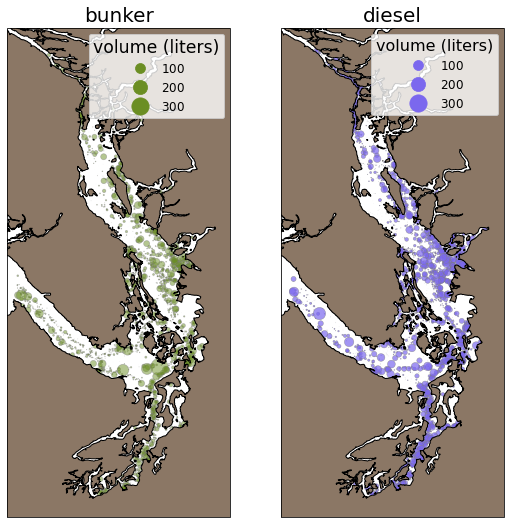

In [73]:
fs = 20
ms = 300
fs_legend = 12
fs_legend_title = 16
import matplotlib.gridspec as gridspec

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

%matplotlib inline    

fig,axs = plt.subplots(
    1, 2, figsize=(9, 9), subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)

terminal_loc = 0
print('working on first graphic')
axs[0].add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='#8b7765'))
scatter_bunker = axs[0].scatter(spill_locs_byoil['bunker'].spill_lon, 
       spill_locs_byoil['bunker'].spill_lat, 
       s = ms * spill_volume_fraction['bunker'],
       label = spill_volume_fraction['bunker'].values.tolist(),
       color=oil_colors[1],
       alpha = 0.5,
       edgecolors='grey',
       linewidth=0.7,
       transform=plain_crs)
handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
legend = axs[0].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize='xx-large')
#axs[0].legend(handles, labels, scatterpoints=3)
axs[0].set_title('bunker', fontsize=fs)

print('working on second graphic')
axs[1].add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='#8b7765'))
scatter_diesel = axs[1].scatter(spill_locs_byoil['diesel'].spill_lon, 
       spill_locs_byoil['diesel'].spill_lat, 
       s = ms * spill_volume_fraction['diesel'],
       color=oil_colors[4],
       alpha = 0.7,
       edgecolors='grey',
       linewidth=0.5,
       transform=plain_crs)
handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[4], num=3, alpha=1)
legend = axs[1].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize=fs_legend_title)
axs[1].set_title('diesel', fontsize=fs)

fig.canvas.draw()
#fig.tight_layout()

index += 1
plt.show()

fig.savefig(output_directory/'oil_spills_for_bunker_diesel.png')

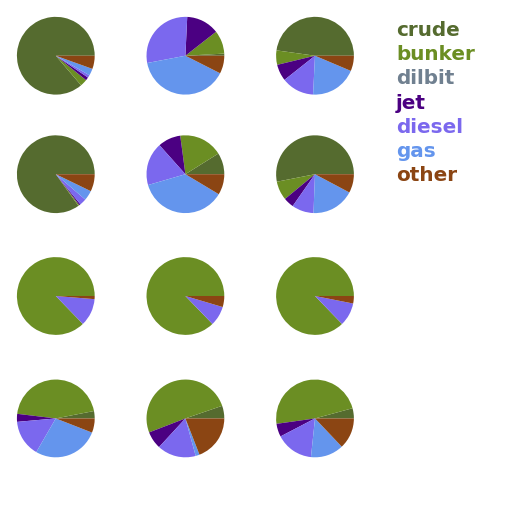

In [72]:
fs = 20
ms = 300
fs_legend = 12
fs_legend_title = 16

fig,axs = plt.subplots(1, 1, figsize=(9, 9))
fig.patch.set_visible(False)
axs.axis('off')

offset=0.03
x = [0.1, 0.3, 0.5]
y = numpy.array([0.01, .1-offset, .2-offset, .3-offset])

#~~~~~~~~~~~~~~~~ NORTH ~~~~~~~~~~~~~~~~~~
# I'm still using latitude just to help get ordering right
ybottom   = ((north.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()
ax_north = fig.add_axes([x[0], ybottom + y[3],.15, .15])
ax_north.pie(north_oils['import'], colors = oil_colors)
ax_north = fig.add_axes([x[1], ybottom + y[3],.15, .15])
ax_north.pie(north_oils['export'], colors = oil_colors)
ax_north = fig.add_axes([x[2], ybottom + y[3],.15, .15])
ax_north.pie(north_oils['net'], colors = oil_colors)

#~~~~~~~~~~~~~~~~ ANACORTES ~~~~~~~~~~~~~~~~~~
ybottom   = ((anacortes.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()
ax_anacortes = fig.add_axes([x[0], ybottom + y[2],.15, .15])
ax_anacortes.pie(anacortes_oils['import'], colors = oil_colors)
ax_anacortes = fig.add_axes([x[1], ybottom + y[2],.15, .15])
ax_anacortes.pie(anacortes_oils['export'], colors = oil_colors)
ax_anacortes = fig.add_axes([x[2], ybottom + y[2],.15, .15])
ax_anacortes.pie(anacortes_oils['net'], colors = oil_colors)

#~~~~~~~~~~~~~~~~ PORT ANGELES ~~~~~~~~~~~~~~~~~~
#xleft = 1.1 #((portangeles.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((portangeles.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()
ax_portangeles = fig.add_axes([x[0], ybottom + y[1],.15, .15])
ax_portangeles.pie(portangeles_oils['import'], colors = oil_colors)
ax_portangeles = fig.add_axes([x[1], ybottom + y[1],.15, .15])
ax_portangeles.pie(portangeles_oils['export'], colors = oil_colors)
ax_portangeles = fig.add_axes([x[2], ybottom + y[1],.15, .15])
ax_portangeles.pie(portangeles_oils['net'], colors = oil_colors)

#~~~~~~~~~~~~~~~~ SOUTH ~~~~~~~~~~~~~~~~~~
#xleft = ((south.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((south.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()
ax_south = fig.add_axes([x[0], ybottom + y[0],.15, .15])
ax_south.pie(south_oils['import'], colors = oil_colors)
ax_south = fig.add_axes([x[1], ybottom + y[0],.15, .15])
ax_south.pie(south_oils['export'], colors = oil_colors)
ax_south = fig.add_axes([x[2], ybottom + y[0],.15, .15])
ax_south.pie(south_oils['net'], colors = oil_colors)

ax_legend = fig.add_axes([.7, .72 ,.15, .15])
ax_legend.axis('off')
for oils in oil_types:
    n = oil_types.index(oils)
    if n==0:
        oils = 'crude'
    plt.text(0, 0.85-n*0.25, oils, fontsize=20, weight = "bold", color = oil_colors[n])
fig.savefig(output_directory/'oil_transfers_by_type.png')

In [49]:
oil_types.index('akns')


0

In [40]:
oil_types

['akns', 'bunker', 'dilbit', 'jet', 'diesel', 'gas', 'other']

working on first graphic
working on second graphic


Text(0.5, 1.0, 'oil transfer volumes')

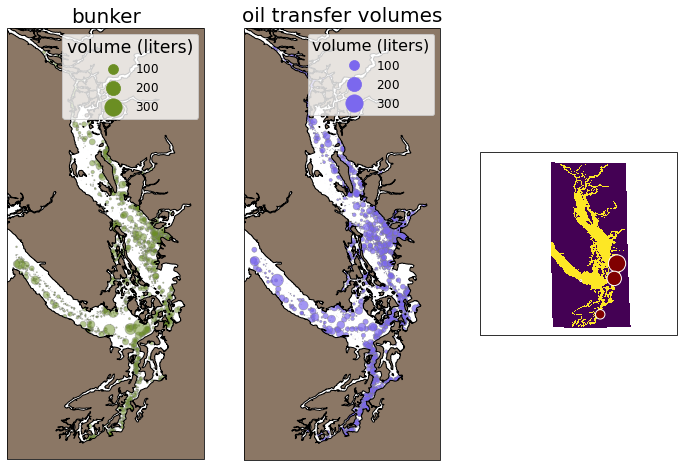

In [16]:
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

%matplotlib inline    

fig,axs = plt.subplots(
    1, 3, figsize=(12, 9), subplot_kw={"projection": rotated_crs, "facecolor": "white"}
)

terminal_loc = 0
print('working on first graphic')
axs[0].add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='#8b7765'))
scatter_bunker = axs[0].scatter(spill_locs_byoil['bunker'].spill_lon, 
       spill_locs_byoil['bunker'].spill_lat, 
       s = ms * spill_volume_fraction['bunker'],
       label = spill_volume_fraction['bunker'].values.tolist(),
       color=oil_colors[1],
       alpha = 0.5,
       edgecolors='grey',
       linewidth=0.7,
       transform=plain_crs)
handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
legend = axs[0].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize='xx-large')
#axs[0].legend(handles, labels, scatterpoints=3)
axs[0].set_title('bunker', fontsize=fs)

print('working on second graphic')
axs[1].add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='#8b7765'))
scatter_diesel = axs[1].scatter(spill_locs_byoil['diesel'].spill_lon, 
       spill_locs_byoil['diesel'].spill_lat, 
       s = ms * spill_volume_fraction['diesel'],
       color=oil_colors[4],
       alpha = 0.7,
       edgecolors='grey',
       linewidth=0.5,
       transform=plain_crs)
handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[4], num=3, alpha=1)
legend = axs[1].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize=fs_legend_title)
axs[1].set_title('diesel', fontsize=fs)

#axs[2].add_feature(feature.GSHHSFeature("full", edgecolor='k', facecolor='#8b7765'))

quad_mesh = axs[2].pcolormesh(
    georef.longitude, georef.latitude, water_mask, transform=plain_crs,  shading="auto"
)

axs[2].set_extent([spill_locs_byoil['diesel'].spill_lon.min(),
                  spill_locs_byoil['diesel'].spill_lon.max(),
                  spill_locs_byoil['diesel'].spill_lat.min(),
                  spill_locs_byoil['diesel'].spill_lat.max()])

scatter_transfers = axs[2].scatter(
    df_net_transfers['longitude'],
    df_net_transfers['latitude'],
    s = 600*(df_net_transfers['oil_volume']/df_net_transfers['oil_volume'].sum()),
    transform=plain_crs, 
    color='maroon',
    edgecolors='white',
    linewidth=1
)
handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[4], num=3, alpha=1)
legend = axs[1].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize=fs_legend_title)
axs[1].set_title('oil transfer volumes', fontsize=fs)

working on first graphic


AttributeError: 'AxesSubplot' object has no attribute 'add_feature'

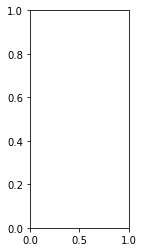

In [17]:
fs = 20
ms = 300
fs_legend = 12
fs_legend_title = 16
import matplotlib.gridspec as gridspec

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()

%matplotlib inline    

# fig,axs = plt.subplots(
#     1, 3, figsize=(15, 9), subplot_kw={"projection": rotated_crs, "facecolor": "white"}
# )

fig = plt.figure()

gs = fig.add_gridspec(1,3)
axs[0] = fig.add_subplot(gs[0, 1])
terminal_loc = 0
print('working on first graphic')
axs[0].add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='#8b7765'))
scatter_bunker = axs[0].scatter(spill_locs_byoil['bunker'].spill_lon, 
       spill_locs_byoil['bunker'].spill_lat, 
       s = ms * spill_volume_fraction['bunker'],
       label = spill_volume_fraction['bunker'].values.tolist(),
       color=oil_colors[1],
       alpha = 0.5,
       edgecolors='grey',
       linewidth=0.7,
       transform=plain_crs)
handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
legend = axs[0].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
plt.setp(legend.get_title(),fontsize='xx-large')
#axs[0].legend(handles, labels, scatterpoints=3)
axs[0].set_title('bunker', fontsize=fs)



# the offsets needed for indexing from lower left of graphic boundary
x = 0.8
offest=0.03
y = numpy.array([0.01, .1 - 0.03, .2 - 0.03, .3 - 0.03])
#~~~~~~~~~~~~~~~~ NORTH ~~~~~~~~~~~~~~~~~~
#xleft = ((north.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((north.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_north = fig.add_axes([x, ybottom + y[3],.15, .15])
ax_north.pie(north_oils['import'], colors = oil_colors)

#~~~~~~~~~~~~~~~~ ANACORTES ~~~~~~~~~~~~~~~~~~
#xleft = ((anacortes.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((anacortes.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_anacortes = fig.add_axes([x, ybottom + y[2],.15, .15])
ax_anacortes.pie(anacortes_oils['import'], colors = oil_colors)

#~~~~~~~~~~~~~~~~ PORT ANGELES ~~~~~~~~~~~~~~~~~~
#xleft = 1.1 #((portangeles.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((portangeles.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_portangeles = fig.add_axes([x, ybottom + y[1],.15, .15])
ax_portangeles.pie(portangeles_oils['import'], colors = oil_colors)

#~~~~~~~~~~~~~~~~ SOUTH ~~~~~~~~~~~~~~~~~~
#xleft = ((south.DockLongNumber[0] - georef.longitude.min())/(georef.longitude.max() - georef.longitude.min())).values.item()
ybottom   = ((south.DockLatNumber[0] - georef.latitude.min())/(georef.latitude.max() - georef.latitude.min())).values.item()

ax_south = fig.add_axes([x, ybottom + y[0],.15, .15])
ax_south.pie(south_oils['import'], colors = oil_colors)
# print('working on second graphic')
# axs[1].add_feature(feature.GSHHSFeature('full', edgecolor='k', facecolor='#8b7765'))
# scatter_diesel = axs[1].scatter(spill_locs_byoil['diesel'].spill_lon, 
#        spill_locs_byoil['diesel'].spill_lat, 
#        s = ms * spill_volume_fraction['diesel'],
#        color=oil_colors[4],
#        alpha = 0.7,
#        edgecolors='grey',
#        linewidth=0.5,
#        transform=plain_crs)
# handles, labels = scatter_bunker.legend_elements(prop="sizes", color=oil_colors[4], num=3, alpha=1)
# legend = axs[1].legend(handles, labels, loc="upper right", title="volume (liters)", fontsize=fs_legend)
# plt.setp(legend.get_title(),fontsize=fs_legend_title)
# axs[1].set_title('diesel', fontsize=fs)

In [ ]:
wa_locs